Fit and save smooth curves to Baker et al step response data.

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import warnings

from aux import loadmat_h5
from disp import set_font_size


DATA_DIR = 'data/original/baker_neur/Auditory_screen_summary'
SPLIT_GAL_4_FILE = 'split_gal_4_line.dat'

FPS = 8.5
DT = 1/FPS

Load data

In [2]:
df_sg4 = pd.read_csv(os.path.join(DATA_DIR, SPLIT_GAL_4_FILE))
cell_label = dict(zip(df_sg4['line'], df_sg4[' name']))

In [3]:
cell_label[16374]

' AVLP_pr01'

In [4]:
expts = []
for x in os.listdir(DATA_DIR):
    if os.path.isdir(os.path.join(DATA_DIR, x)):
        if np.any([y.endswith('summary.mat') for y in os.listdir(os.path.join(DATA_DIR, x))]):                     
            expts.append(x)
expts = sorted(expts)

mean_rsps_all = {}
rois_all = {}
rois_used_all = {}

for expt in expts:
    expt_dir = os.path.join(DATA_DIR, expt)
    mat_file = [f_name for f_name in os.listdir(expt_dir) if f_name.endswith('.mat')][0]

    sys.stdout.write('.')
    d = loadmat_h5(os.path.join(expt_dir, mat_file))

    mean_rsps = d['allMeanResponses'].flatten()
    rois = d['screen']['roi'].flatten()
    rois_to_use = d['screen']['ROItoUse']
    
    if rois_to_use.ndim == 1:
        rois_to_use = np.array([], dtype=float)
    else:
        rois_to_use = rois_to_use.flatten() - 1
    rois_used = np.zeros(len(rois), dtype=bool)
    rois_used[rois_to_use.astype(int)] = True
    
    mean_rsps_all[expt] = mean_rsps
    rois_all[expt] = rois
    rois_used_all[expt] = rois_used

..................................................

In [5]:
mean_rsps_all[expts[0]][0].shape  # (stims, timesteps, flies)

(3, 300, 5)

In [6]:
{expt: (rois_all[expt], rois_used_all[expt]) for expt in expts}

{'R70G01': (array(['somas', 'AMMC projection'], dtype=object),
  array([False, False])),
 'R72E10': (array(['somas'], dtype=object), array([False])),
 'SS16374': (array(['somas', 'wedge'], dtype=object), array([ True, False])),
 'SS21914': (array(['somas'], dtype=object), array([ True])),
 'SS23281': (array(['wedge', 'somas', 'junction'], dtype=object),
  array([ True, False, False])),
 'SS27880': (array(['vlp'], dtype=object), array([ True])),
 'SS27885': (array(['somas', 'wedge'], dtype=object), array([ True, False])),
 'SS27919': (array(['wedge'], dtype=object), array([ True])),
 'SS27932': (array(['wedge', 'dorsal proj'], dtype=object),
  array([False,  True])),
 'SS27933': (array(['wedge', 'dorsal proj'], dtype=object),
  array([False, False])),
 'SS27936': (array(['somas', 'wedge', 'ascending proj'], dtype=object),
  array([ True, False, False])),
 'SS28542': (array(['ascending projection', 'junction', 'somas'], dtype=object),
  array([False, False, False])),
 'SS28822': (array([

In [7]:
t = np.arange(300) * DT - 10
t_start = 0
t_end = 10

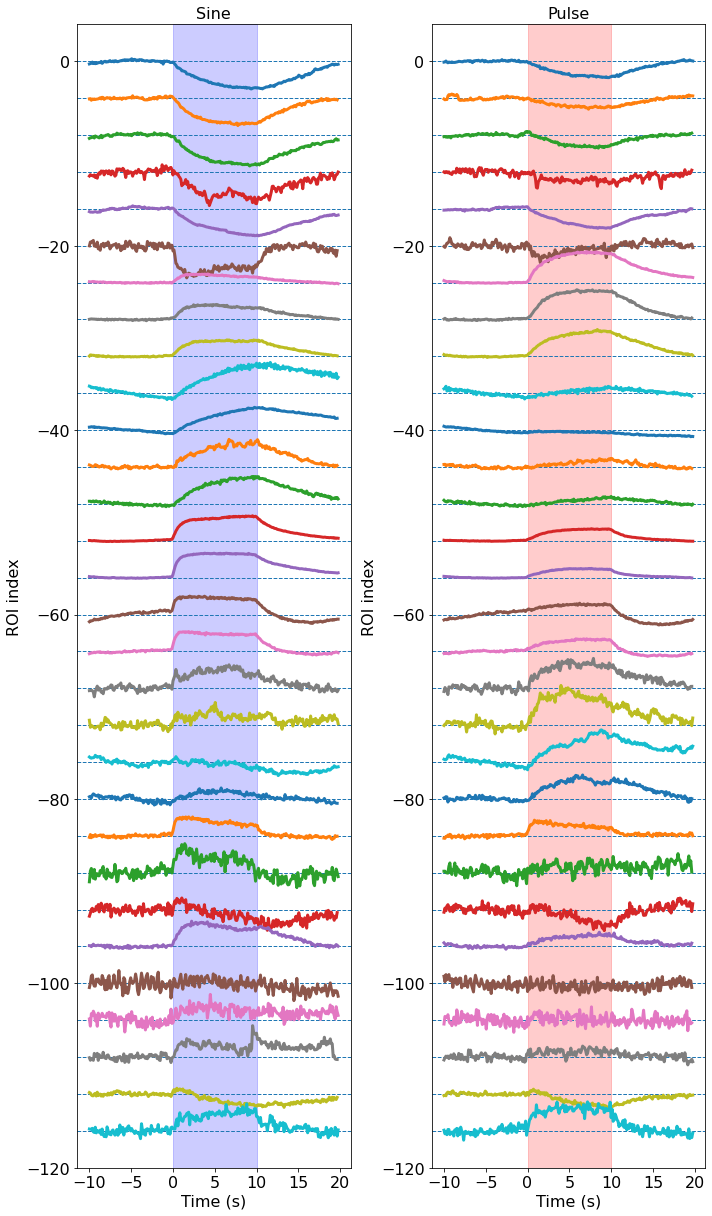

In [8]:
nroi_plot = 30

fig, axs = plt.subplots(1, 2, figsize=(10, 17), tight_layout=True)
croi = 0

named_cols = ['EXPT_ID', 'STIM', 'LINE', 'FLY', 'ROI', 'ROI_USED']
t_cols = [f'IT_{ct}' for ct in range(len(t))]
columns = named_cols + t_cols

df_data = []
for expt in expts:
    mean_rsps = mean_rsps_all[expt]
    rois = rois_all[expt]
    rois_used = rois_used_all[expt]
    
    try:
        label_full = cell_label[int(expt[2:])]
    except:
        label_full = expt
        
    label = label_full[:20]

    for mean_rsp, roi, roi_used in zip(mean_rsps, rois, rois_used):

        if mean_rsp.ndim == 2:
            mean_rsp = mean_rsp[:, :, None]

        n_stim, n_t, n_fly = mean_rsp.shape

        mt = (t_start <= t)&(t < t_end)
        
        for cf in range(n_fly):

            std_total = np.nanstd(mean_rsp[:, :, cf])
            
            rsp_s = mean_rsp[1, :, cf] / std_total
            rsp_p = mean_rsp[0, :, cf] / std_total
            
            if croi < nroi_plot:
                axs[0].axhline(-4*croi, lw=1, ls='--')
                axs[0].plot(t, rsp_s - 4*croi, lw=3)

                axs[1].axhline(-4*croi, lw=1, ls='--')
                axs[1].plot(t, rsp_p - 4*croi, lw=3)
            
            # add to data list for csv file
            row_s = {'EXPT_ID': croi, 'STIM': 'S', 'LINE': expt.replace(',', ' '), 'FLY': cf, 'ROI': roi.replace(',', ' '), 'ROI_USED': roi_used}
            row_p = {'EXPT_ID': croi, 'STIM': 'P', 'LINE': expt.replace(',', ' '), 'FLY': cf, 'ROI': roi.replace(',', ' '), 'ROI_USED': roi_used}
            
            for ct in range(len(t)):
                row_s[f'IT_{ct}'] = rsp_s[ct]
                row_p[f'IT_{ct}'] = rsp_p[ct]
            
            df_data.extend([row_s, row_p])
            croi += 1
            
for ax, c, stim in zip(axs, ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(t_start, t_end, color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(-120, 4)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('ROI index')

set_font_size(axs, 16)

In [9]:
df_mean_rsp = pd.DataFrame(columns=columns, data=df_data)
df_mean_rsp.to_csv('data/simple/neur/baker.csv', index=False)

In [10]:
df_mean_rsp

,EXPT_ID,STIM,LINE,FLY,ROI,ROI_USED,IT_0,IT_1,IT_2,IT_3,...,IT_290,IT_291,IT_292,IT_293,IT_294,IT_295,IT_296,IT_297,IT_298,IT_299
0,0,S,R70G01,0,somas,False,-0.286139,-0.251529,-0.214845,-0.085881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,P,R70G01,0,somas,False,-0.090690,-0.071585,0.027546,-0.089212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,S,R70G01,1,somas,False,-0.074163,-0.052967,-0.226459,-0.086673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,P,R70G01,1,somas,False,-0.094280,-0.175828,-0.132839,-0.155376,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,S,R70G01,2,somas,False,-0.359071,-0.296972,-0.283760,-0.206650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,221,P,vPN1_split,0,somas,False,0.308926,0.069519,-0.028961,-0.103122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444,222,S,vPN1_split,1,somas,False,0.268154,0.517779,0.526319,0.353496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445,222,P,vPN1_split,1,somas,False,0.563747,0.506288,0.271983,0.002747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,223,S,vPN1_split,2,somas,False,0.023391,0.023677,0.009701,0.006185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
